In [ ]:
#!pip istall xgboost

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [11]:

bookings=pd.read_csv('cleaned_hotel_booking.csv')
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87396 entries, 0 to 87395
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87396 non-null  float64
 11  babies                          87396 non-null  int64  
 12  meal                            

In [4]:
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,14.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,14.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,14.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [12]:
# حذف ستون‌های نامناسب
bookings_clean = bookings.drop([
    'reservation_status_date',
    'reservation_status',
    'agent',
    'country'
], axis=1)

# تبدیل ستون‌های object به category
for col in bookings_clean.select_dtypes(include=['object']).columns:
    bookings_clean[col] = bookings_clean[col].astype('category')

# Label Encoding
label_cols = ['deposit_type', 'customer_type', 'meal']
for col in label_cols:
    bookings_clean[col] = LabelEncoder().fit_transform(bookings_clean[col])

# One-Hot Encoding
nominal_cols = [
    'hotel', 'arrival_date_month', 'market_segment',
    'distribution_channel', 'reserved_room_type', 'assigned_room_type'
]

bookings_clean = pd.get_dummies(
    bookings_clean,
    columns=nominal_cols,
    drop_first=True
)

In [13]:

# تقسیم داده
X = bookings_clean.drop('is_canceled', axis=1)
y = bookings_clean['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)


In [15]:

# مدل‌سازی
xgb_clf = xgb.XGBClassifier(
    n_estimators=10,
    random_state=123,
    eval_metric='logloss',  # برای طبقه‌بندی دودویی
)
xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test)

In [6]:

bookings_clean.corr()['is_canceled'].sort_values(ascending=False)

is_canceled                     1.000000
market_segment_Online TA        0.211363
lead_time                       0.184806
distribution_channel_TA/TO      0.151642
deposit_type                    0.137545
                                  ...   
market_segment_Direct          -0.113067
distribution_channel_Direct    -0.118549
total_of_special_requests      -0.120545
market_segment_Offline TA/TO   -0.123029
required_car_parking_spaces    -0.184206
Name: is_canceled, Length: 64, dtype: float64

In [16]:
accuracy = float(np.sum(preds==y_test))/len(y_test)
print('Baseline aaccuracy: ',accuracy )

Baseline aaccuracy:  0.8030234735272702


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

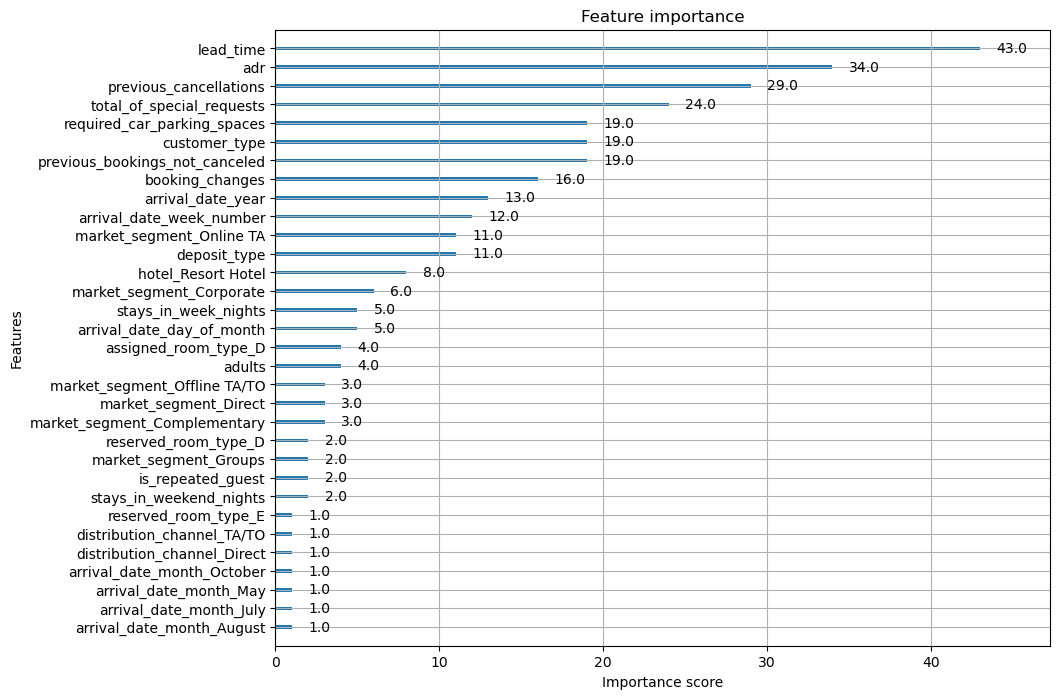

In [17]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,8)
xgb.plot_importance(xgb_clf)

In [18]:
bookings_dmatrix= xgb.DMatrix(data=X, label=y)

In [19]:
params = {"objective": "binary:logistic", 'max_depth':3}
xgb_cv = xgb.cv(dtrain=bookings_dmatrix, params=params, nfold=3, num_boost_round=10, seed=123, metrics=['error'])
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.274898,0.000071,0.274898,0.000141
1,0.274898,0.000071,0.274898,0.000141
2,0.267999,0.000313,0.267953,0.000101
3,0.265035,0.003575,0.265115,0.003575
4,0.213231,0.002217,0.213786,0.002739
5,0.218500,0.006381,0.218523,0.005637
6,0.210130,0.001599,0.210502,0.001156
7,0.208230,0.001354,0.208694,0.000949
8,0.207801,0.001067,0.207881,0.000303
9,0.206485,0.001838,0.206440,0.001122


In [20]:
params = {"objective": "binary:logistic", 'max_depth':3}
xgb_cv = xgb.cv(dtrain=bookings_dmatrix, params=params, nfold=3, num_boost_round=30, seed=123, metrics=['error'])
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.274898,0.000071,0.274898,0.000141
1,0.274898,0.000071,0.274898,0.000141
2,0.267999,0.000313,0.267953,0.000101
3,0.265035,0.003575,0.265115,0.003575
4,0.213231,0.002217,0.213786,0.002739
5,0.218500,0.006381,0.218523,0.005637
6,0.210130,0.001599,0.210502,0.001156
7,0.208230,0.001354,0.208694,0.000949
8,0.207801,0.001067,0.207881,0.000303
9,0.206485,0.001838,0.206440,0.001122


In [23]:
from sklearn.metrics import accuracy_score
xgb_clf = xgb.XGBClassifier(n_estimators=25, random_state=123)

In [24]:
xgb_clf.set_params(max_depth=10)
xgb_clf.fit(X_train, y_train)
preds= xgb_clf.predict(X_test)
accuracy_score(y_test, preds)

0.8168579452862245

In [29]:
from sklearn.model_selection import RandomizedSearchCV

rs_param_grid={
    'max_depth': list((range(3,12))),
    'alpha':[0,0.001,0.01,0.1,1],
    'subsample':[0.5,0.75,1],
    'learning_rate': np.linspace(0.01,0.5,10),
    'n_estimators': [10,25,40]
}
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_rs = RandomizedSearchCV(estimator=xgb_clf, param_distributions=rs_param_grid,
                            cv=3, n_iter=5, verbose=2, random_state=123)
xgb_rs.fit(X_train, y_train)
print("Best parameters:", xgb_rs.best_params_)
print("Best score:", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.2s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.1s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.4s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.4s
[CV] END